# IDR to CNY, CAD, and MYR currency model

In [1]:
%run helper_functions_and_libraries.py
logging.set_verbosity(logging.ERROR)

In [2]:
df = pd.read_csv('currency_data_10_years.csv', parse_dates=['date'])

In [3]:
display(df.head())

,date,EUR,USD,JPY,GBP,SGD,AUD,CNY,CAD,MYR,RUB
0,2013-05-01,12816.661099,9721.95011,99.794970,15125.789759,7884.025975,9991.932116,1573.729510,9637.238781,3196.705985,311.579294
1,2013-05-02,12696.355896,9727.31307,99.371194,15096.787469,7878.089194,9976.629029,1576.636811,9620.049518,3193.114711,311.787545
2,2013-05-03,12735.428571,9726.93828,98.682506,15125.784565,7879.444847,10024.671009,1576.977359,9628.439345,3201.788787,312.272389
3,2013-05-04,12758.622548,9729.21521,98.372041,15148.170100,7886.016560,10037.051582,1577.842772,9643.293465,3204.827462,313.177271
4,2013-05-05,12719.240307,9697.65758,97.852512,15097.625177,7859.545641,9999.337595,1572.747845,9623.460698,3195.832412,312.291932


In [4]:
df.isnull().sum()

date    0
EUR     0
USD     0
JPY     0
GBP     0
SGD     0
AUD     0
CNY     0
CAD     0
MYR     0
RUB     0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df.describe()

,EUR,USD,JPY,GBP,SGD,AUD,CNY,CAD,MYR,RUB
count,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000
mean,15734.162882,13626.586201,121.401374,18653.481260,10082.717169,10260.649080,2069.300203,10754.881120,3404.138908,231.530939
std,1028.194122,1215.902129,10.240113,1282.776928,714.681696,449.989173,140.321208,530.164824,173.826533,46.941534
min,12502.789487,9697.657580,94.607603,14719.776369,7717.296664,8937.081757,1572.747845,9357.856739,2975.634017,102.737302
25%,15022.483609,13190.926920,113.522422,17928.531116,9568.972790,9936.471898,1980.528819,10411.948518,3302.096195,201.594311
50%,15801.743633,13912.643820,120.609803,18781.087788,10247.419202,10276.735571,2091.106976,10746.358863,3423.539036,219.833077
75%,16463.962255,14384.106330,129.598188,19469.502233,10588.733799,10609.276367,2177.005363,11165.293022,3529.477813,237.545901
max,18035.467645,16644.718800,153.504275,22488.120204,11718.909446,11396.359940,2346.805612,12314.949757,3819.207831,384.795234


In [7]:
SPLIT_TIME = 3287
WINDOW_SIZE = 30
BATCH_SIZE = 120
SHUFFLE_BUFFER_SIZE = 1000

## CNY

In [8]:
cny_df = df[['date','CNY']]

display(cny_df.head())
display(cny_df.tail())

,date,CNY
0,2013-05-01,1573.729510
1,2013-05-02,1576.636811
2,2013-05-03,1576.977359
3,2013-05-04,1577.842772
4,2013-05-05,1572.747845


,date,CNY
3648,2023-04-27,2122.230600
3649,2023-04-28,2122.847288
3650,2023-04-29,2122.846296
3651,2023-04-30,2122.366433
3652,2023-05-01,2123.377747


In [9]:
times, series = parse_data_from_df(cny_df, 'CNY')

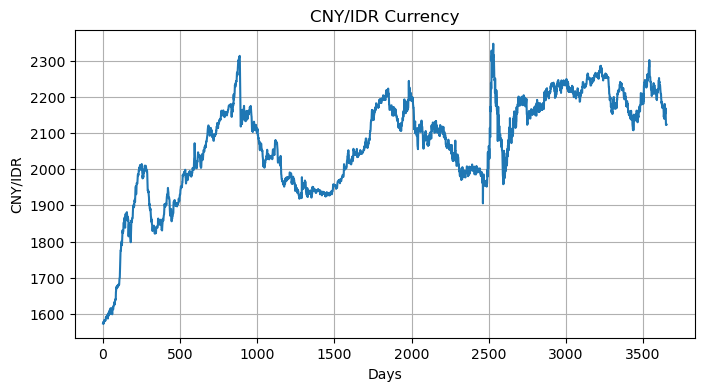

In [10]:
plt.figure(figsize=(8, 4))
plot_series(times, series, title="CNY/IDR Currency", xlabel="Days", ylabel="CNY/IDR")

In [11]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(times, series, SPLIT_TIME, None)

# Make windowed dataset
train_set = windowed_dataset(series_train, 
                             window_size=WINDOW_SIZE, 
                             batch_size=BATCH_SIZE, 
                             shuffle_buffer=SHUFFLE_BUFFER_SIZE)

val_set = windowed_dataset(series_valid, 
                             window_size=WINDOW_SIZE, 
                             batch_size=BATCH_SIZE, 
                             shuffle_buffer=SHUFFLE_BUFFER_SIZE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosi

In [31]:
def create_model():
    
    # Build the model
    model = tf.keras.models.Sequential([
#         tf.keras.layers.Embedding(10000, 128),
#         tf.keras.layers.SimpleRNN(64, return_sequences=True),
#         tf.keras.layers.SimpleRNN(64),
        tf.keras.layers.Dense(128,input_shape=[WINDOW_SIZE], activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(32, activation="swish", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(16, activation="swish", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ], name="model_cny")

    return model

In [32]:
# Test your uncompiled model
model = create_model()

# Print the model summary
model.summary()

# Check model compatibility
try:
    model.predict(train_set)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

Model: "model_cny"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3968      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 14,849
Trainable params: 14,849
Non-trainable params: 0
_________________________________________________________________
28/28 [==============================] - 0s 8ms/step


In [33]:
# Get initial weights
init_weights = model.get_weights()

# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [34]:
def adjust_learning_rate(dataset, model_to_train):
    
    model = model_to_train
    
    # Set the learning rate scheduler
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * 10**(epoch / 20))
    
    # Select optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"])
    
    # Train the model
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [35]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set, model)

Epoch 1/100
28/28 [==============================] - 1s 9ms/step - loss: 276.6518 - mae: 275.4180 - lr: 0.0010
Epoch 2/100
28/28 [==============================] - 0s 8ms/step - loss: 24.1072 - mae: 23.2842 - lr: 0.0011
Epoch 3/100
28/28 [==============================] - 0s 8ms/step - loss: 27.5638 - mae: 27.0314 - lr: 0.0013
Epoch 4/100
28/28 [==============================] - 0s 8ms/step - loss: 23.5424 - mae: 23.1875 - lr: 0.0014
Epoch 5/100
28/28 [==============================] - 0s 8ms/step - loss: 24.1964 - mae: 23.9431 - lr: 0.0016
Epoch 6/100
28/28 [==============================] - 0s 8ms/step - loss: 35.5042 - mae: 35.3044 - lr: 0.0018
Epoch 7/100
28/28 [==============================] - 0s 8ms/step - loss: 24.6446 - mae: 24.4675 - lr: 0.0020
Epoch 8/100
28/28 [==============================] - 0s 8ms/step - loss: 33.1990 - mae: 33.0352 - lr: 0.0022
Epoch 9/100
28/28 [==============================] - 0s 8ms/step - loss: 66.5348 - mae: 66.3747 - lr: 0.0025
Epoch 10/100
28/2

28/28 [==============================] - 0s 9ms/step - loss: 752.1580 - mae: 102.3612 - lr: 4.4668
Epoch 75/100
28/28 [==============================] - 0s 8ms/step - loss: 779.8621 - mae: 139.0981 - lr: 5.0119
Epoch 76/100
28/28 [==============================] - 0s 9ms/step - loss: 736.4880 - mae: 103.6894 - lr: 5.6234
Epoch 77/100
28/28 [==============================] - 0s 9ms/step - loss: 822.1796 - mae: 196.3938 - lr: 6.3096
Epoch 78/100
28/28 [==============================] - 0s 9ms/step - loss: 816.3708 - mae: 189.2518 - lr: 7.0795
Epoch 79/100
28/28 [==============================] - 0s 9ms/step - loss: 747.4119 - mae: 119.6851 - lr: 7.9433
Epoch 80/100
28/28 [==============================] - 0s 8ms/step - loss: 762.0643 - mae: 139.9559 - lr: 8.9125
Epoch 81/100
28/28 [==============================] - 0s 8ms/step - loss: 945.1046 - mae: 194.4558 - lr: 10.0000
Epoch 82/100
28/28 [==============================] - 0s 9ms/step - loss: 953.5665 - mae: 139.5879 - lr: 11.2202
Epo

In [36]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [37]:
def compile_model(dataset, model_to_train):
    
    model = model_to_train

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    history = model.fit(dataset,
                        verbose=1,
                        epochs=100,
                        validation_data=val_set)   

    return history

In [38]:
history = compile_model(train_set, model)

Epoch 1/100
28/28 [==============================] - 2s 17ms/step - loss: 1347.8833 - mae: 1346.4392 - val_loss: 755.9782 - val_mae: 754.5634
Epoch 2/100
28/28 [==============================] - 0s 11ms/step - loss: 249.2417 - mae: 247.8513 - val_loss: 33.8144 - val_mae: 32.4496
Epoch 3/100
28/28 [==============================] - 0s 14ms/step - loss: 28.4692 - mae: 27.1272 - val_loss: 23.2869 - val_mae: 21.9718
Epoch 4/100
28/28 [==============================] - 0s 12ms/step - loss: 18.6665 - mae: 17.3685 - val_loss: 19.3713 - val_mae: 18.1032
Epoch 5/100
28/28 [==============================] - 0s 11ms/step - loss: 18.8516 - mae: 17.6034 - val_loss: 19.9630 - val_mae: 18.7423
Epoch 6/100
28/28 [==============================] - 0s 11ms/step - loss: 18.2605 - mae: 17.0567 - val_loss: 19.4107 - val_mae: 18.2329
Epoch 7/100
28/28 [==============================] - 0s 11ms/step - loss: 18.2575 - mae: 17.0972 - val_loss: 19.7239 - val_mae: 18.5906
Epoch 8/100
28/28 [=====================

Epoch 61/100
28/28 [==============================] - 0s 13ms/step - loss: 14.6155 - mae: 14.3822 - val_loss: 15.3789 - val_mae: 15.1500
Epoch 62/100
28/28 [==============================] - 0s 13ms/step - loss: 14.3970 - mae: 14.1681 - val_loss: 15.4404 - val_mae: 15.2152
Epoch 63/100
28/28 [==============================] - 1s 14ms/step - loss: 13.7576 - mae: 13.5294 - val_loss: 16.4162 - val_mae: 16.1905
Epoch 64/100
28/28 [==============================] - 0s 13ms/step - loss: 13.7986 - mae: 13.5770 - val_loss: 14.9189 - val_mae: 14.6986
Epoch 65/100
28/28 [==============================] - 0s 13ms/step - loss: 13.9476 - mae: 13.7298 - val_loss: 14.8178 - val_mae: 14.6007
Epoch 66/100
28/28 [==============================] - 0s 13ms/step - loss: 13.8084 - mae: 13.5943 - val_loss: 15.1954 - val_mae: 14.9882
Epoch 67/100
28/28 [==============================] - 0s 13ms/step - loss: 13.4192 - mae: 13.2080 - val_loss: 16.0691 - val_mae: 15.8571
Epoch 68/100
28/28 [=====================

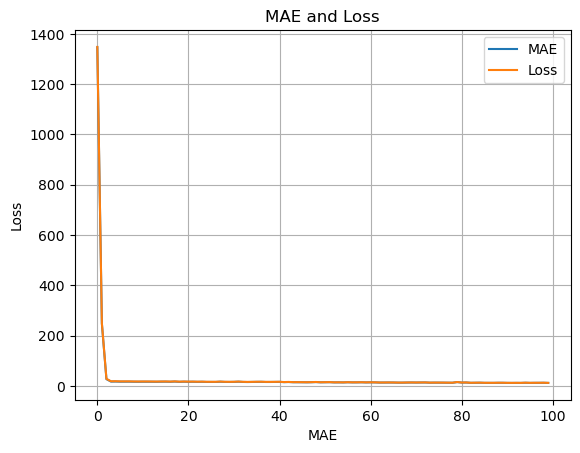

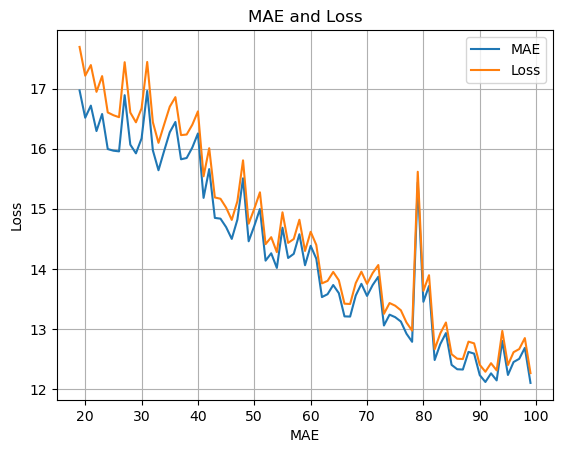

In [39]:
visualize_mae_loss(history)

In [40]:
pred_series = series[SPLIT_TIME-WINDOW_SIZE:-1]

In [41]:
forecast = model_forecast(model, pred_series, WINDOW_SIZE, BATCH_SIZE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - 0s 16ms/step


In [42]:
results = forecast.squeeze()

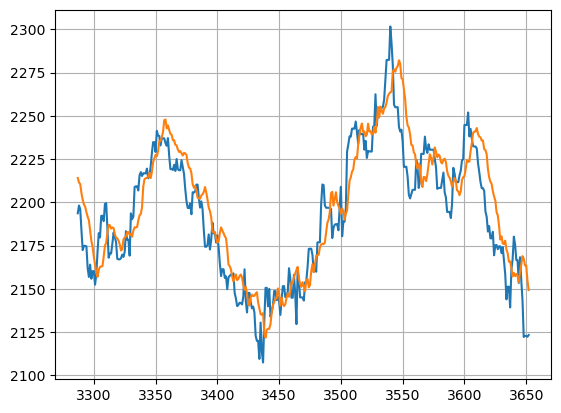

In [43]:
plot_series(time_valid, (series_valid, results))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - 0s 15ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the T

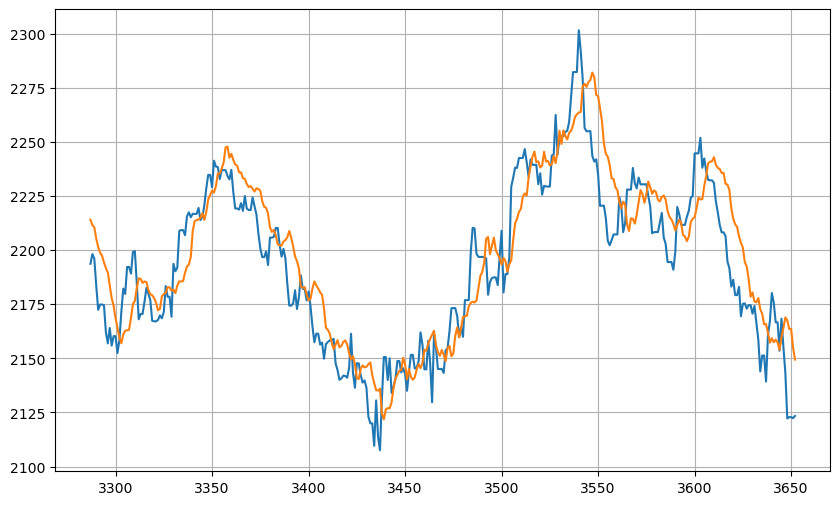

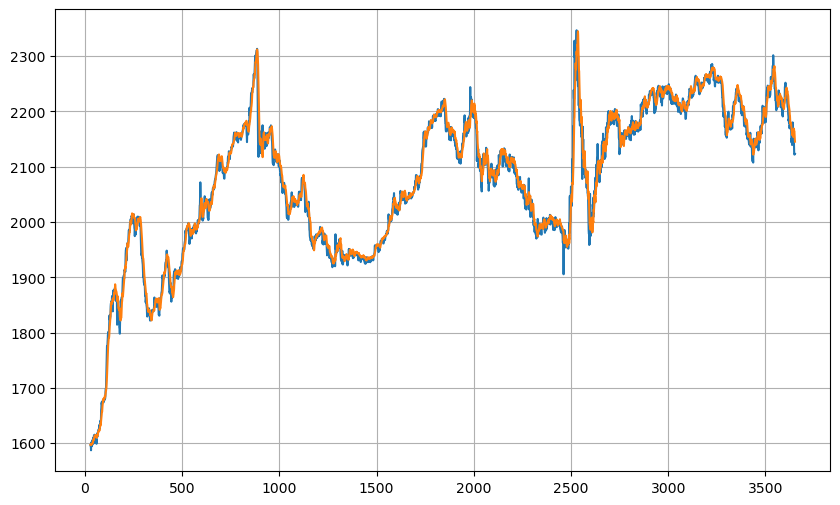

In [44]:
forecast_validator = evaluate_forecast(model, times, series, time_valid, series_valid,
                      SPLIT_TIME, -1, WINDOW_SIZE, BATCH_SIZE)

In [45]:
compute_metrics(series_valid, forecast_validator)

{'mae': 42.363327, 'mse': 2733.599, 'rmse': 50.481007, 'mape': 1.9341565}

In [50]:
into_future = 60

future_forecast = make_future_forecast(values=series,
                                       model=model,
                                       into_future=into_future,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 22ms/step
Predicting on:
 [[2182.99447 ]
 [2169.431684]
 [2175.208395]
 [2175.377683]
 [2172.950787]
 [2174.590884]
 [2174.588548]
 [2170.647263]
 [2174.198474]
 [2166.398662]
 [2158.608099]
 [2143.968406]
 [2151.283688]
 [2151.283945]
 [2139.301556]
 [2160.963846]
 [2167.103322]
 [2180.189295]
 [2175.728884]
 [2166.646358]
 [2166.64544 ]
 [2153.476973]
 [2168.304646]
 [2155.150279]
 [2143.414697]
 [2122.2306  ]
 [2122.847288]
 [2122.846296]
 [2122.366433]
 [2123.377747]] -> Prediction: 2145.267333984375

1/1 [==============================] - 0s 19ms/step
Predicting on:
 [2169.431684   2175.208395   2175.377683   2172.950787   2174.590884
 2174.588548   2170.647263   2174.198474   2166.398662   2158.608099
 2143.968406   2151.283688   2151.283945   2139.301556   2160.963846
 2167.103322   2180.189295   2175.728884   2166.646358   2166.64544
 2153.476973   2168.304646   2155.150279   2143.414697   2122.2306
 2122.847288   2122.846296   2122.366

1/1 [==============================] - 0s 26ms/step
Predicting on:
 [2167.103322   2180.189295   2175.728884   2166.646358   2166.64544
 2153.476973   2168.304646   2155.150279   2143.414697   2122.2306
 2122.847288   2122.846296   2122.366433   2123.377747   2145.26733398
 2136.47900391 2138.54980469 2132.95532227 2131.79956055 2128.56640625
 2128.64575195 2132.84082031 2137.42114258 2143.39916992 2148.3215332
 2145.16235352 2146.96362305 2140.35229492 2137.32983398 2136.19067383] -> Prediction: 2134.692626953125

1/1 [==============================] - 0s 27ms/step
Predicting on:
 [2180.189295   2175.728884   2166.646358   2166.64544    2153.476973
 2168.304646   2155.150279   2143.414697   2122.2306     2122.847288
 2122.846296   2122.366433   2123.377747   2145.26733398 2136.47900391
 2138.54980469 2132.95532227 2131.79956055 2128.56640625 2128.64575195
 2132.84082031 2137.42114258 2143.39916992 2148.3215332  2145.16235352
 2146.96362305 2140.35229492 2137.32983398 2136.19067383 213

1/1 [==============================] - 0s 21ms/step
Predicting on:
 [2138.54980469 2132.95532227 2131.79956055 2128.56640625 2128.64575195
 2132.84082031 2137.42114258 2143.39916992 2148.3215332  2145.16235352
 2146.96362305 2140.35229492 2137.32983398 2136.19067383 2134.69262695
 2138.19897461 2137.69067383 2140.18481445 2138.90185547 2134.56567383
 2138.26538086 2140.48217773 2145.0925293  2143.57250977 2144.5625
 2147.0300293  2143.91235352 2143.0090332  2145.97680664 2146.40063477] -> Prediction: 2149.361328125

1/1 [==============================] - 0s 33ms/step
Predicting on:
 [2132.95532227 2131.79956055 2128.56640625 2128.64575195 2132.84082031
 2137.42114258 2143.39916992 2148.3215332  2145.16235352 2146.96362305
 2140.35229492 2137.32983398 2136.19067383 2134.69262695 2138.19897461
 2137.69067383 2140.18481445 2138.90185547 2134.56567383 2138.26538086
 2140.48217773 2145.0925293  2143.57250977 2144.5625     2147.0300293
 2143.91235352 2143.0090332  2145.97680664 2146.40063477

1/1 [==============================] - 0s 19ms/step
Predicting on:
 [2137.69067383 2140.18481445 2138.90185547 2134.56567383 2138.26538086
 2140.48217773 2145.0925293  2143.57250977 2144.5625     2147.0300293
 2143.91235352 2143.0090332  2145.97680664 2146.40063477 2149.36132812
 2150.64160156 2153.91259766 2152.99682617 2151.95214844 2151.02197266
 2149.36547852 2150.06860352 2150.95117188 2153.07861328 2156.15209961
 2156.08740234 2157.34301758 2156.83276367 2156.96875    2157.43725586] -> Prediction: 2157.643798828125

1/1 [==============================] - 0s 22ms/step
Predicting on:
 [2140.18481445 2138.90185547 2134.56567383 2138.26538086 2140.48217773
 2145.0925293  2143.57250977 2144.5625     2147.0300293  2143.91235352
 2143.0090332  2145.97680664 2146.40063477 2149.36132812 2150.64160156
 2153.91259766 2152.99682617 2151.95214844 2151.02197266 2149.36547852
 2150.06860352 2150.95117188 2153.07861328 2156.15209961 2156.08740234
 2157.34301758 2156.83276367 2156.96875    2157.4

In [51]:
start_future = times[-1] + 1
future_time = np.arange(start_future, start_future + into_future)

# Insert last timestep/final price into next time steps and future forecasts so the plot connects
future_time = np.insert(future_time, 0, times[-1])
future_forecast = np.insert(future_forecast, 0, series[-1])

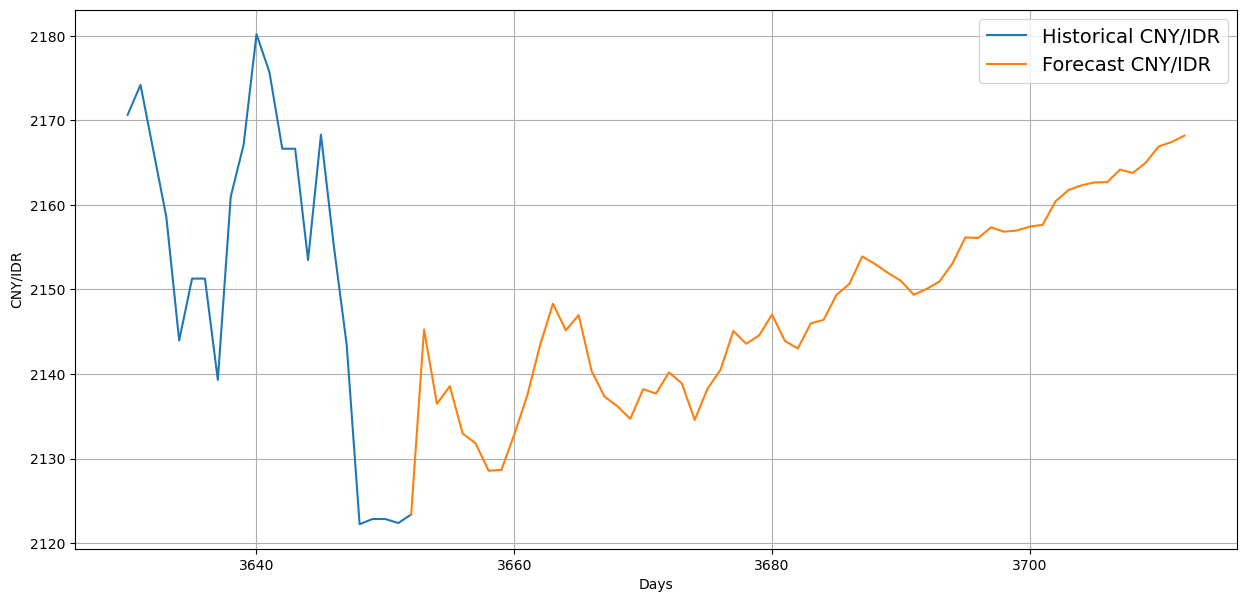

In [52]:
plt.figure(figsize=(15,7))
plot_future_forecast(times, series, start=3630, format="-", label="Historical CNY/IDR", xlabel="Days", ylabel="CNY/IDR")
plot_future_forecast(future_time, future_forecast, format="-", label="Forecast CNY/IDR", xlabel="Days", ylabel="CNY/IDR")

In [53]:
path = get_model_dir("./saved_model/{}".format(model.name)+"/swish")
model.save(path)

INFO:tensorflow:Assets written to: ./saved_model/model_cny/swish/1/assets


INFO:tensorflow:Assets written to: ./saved_model/model_cny/swish/1/assets
